In [5]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from keras.applications.inception_v3 import InceptionV3, preprocess_input


# from google.colab import drive
# drive.mount("/content/gdrive")

In [6]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/Balanced_Training_Input_Aug/"

In [7]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    data_format="channels_last")

In [8]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
train_generator = datagen.flow_from_directory(
                    directory=path_to_images,
                    target_size=(299, 299),
                    batch_size=32,
                    classes=classes,
                    shuffle=True)

Found 32756 images belonging to 7 classes.


In [9]:
samples = train_generator.samples

In [10]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.05108458 0.69790135 1.11071174 1.10078301 1.0644742  1.07895517
 1.0630233 ]


# DEFINING THE MODEL

In [13]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer=RMSprop(lr=1e-4), metrics=["accuracy"])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [14]:
batch_size = 32
epochs = 2
history = model.fit_generator(train_generator, 
                              epochs=epochs,
                              class_weight=class_weights,
                              steps_per_epoch=samples / batch_size,
                              verbose=1)

Epoch 1/2
1024/1023 [==============================] - 347s 339ms/step - loss: 1.1564 - acc: 0.5718
Epoch 2/2
1024/1023 [==============================] - 349s 341ms/step - loss: 0.8968 - acc: 0.6699


In [15]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [17]:
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])
epochs = 10
batch_size = 32
history = model.fit_generator(train_generator, 
                              steps_per_epoch=samples / batch_size,
                              epochs=epochs,
                              class_weight=class_weights,
                              verbose=1)
model.save_weights(drive_base_path + 'models/InceptionV3Net_ISIC_cnn.h5')

Epoch 1/10
1024/1023 [==============================] - 350s 341ms/step - loss: 0.5821 - acc: 0.7957
Epoch 2/10
1024/1023 [==============================] - 350s 342ms/step - loss: 0.4709 - acc: 0.8382
Epoch 3/10
1024/1023 [==============================] - 347s 339ms/step - loss: 0.4069 - acc: 0.8633
Epoch 4/10
1024/1023 [==============================] - 348s 340ms/step - loss: 0.3500 - acc: 0.8825
Epoch 5/10
1024/1023 [==============================] - 347s 339ms/step - loss: 0.3134 - acc: 0.8935
Epoch 6/10
1024/1023 [==============================] - 348s 340ms/step - loss: 0.2712 - acc: 0.9120
Epoch 7/10
1024/1023 [==============================] - 343s 335ms/step - loss: 0.2454 - acc: 0.9213
Epoch 8/10
1024/1023 [==============================] - 340s 332ms/step - loss: 0.2186 - acc: 0.9307
Epoch 9/10
1024/1023 [==============================] - 328s 320ms/step - loss: 0.1702 - acc: 0.9484


# ACCURACY AND LOSS PLOTS

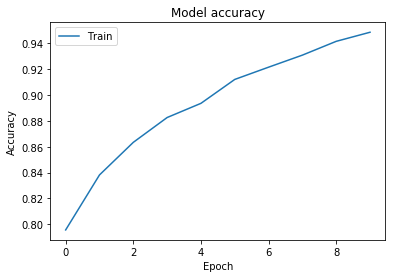

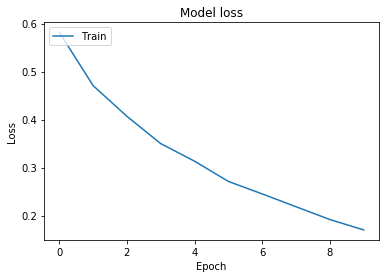

In [18]:
# Plot Training and Validation Accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CONFUSION MATRIX

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

y_test = y_train[:500]
X_test = X_train[:500]

y_pred = model.predict_generator(datagen.flow(X_test, batch_size=1), steps=len(X_test))

In [ ]:
y_pred = (y_pred > 0.5).astype(np.int)
y_test = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [19]:
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [23]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 299
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (input_size, input_size))

        arr = np.array(image)
        images_list.append(image)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [24]:
x_test, names = preprocess_images(path_to_images)

In [25]:
print(x_test.shape)
print(names.shape)

(1512, 299, 299, 3)
(1512, 1)


In [26]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    data_format="channels_last")

# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     data_format="channels_last")

In [27]:
# datagen.fit(x_test)

In [28]:
test_generator = datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [29]:
model.load_weights(drive_base_path + 'models/InceptionV3Net_ISIC_cnn.h5')

In [30]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [31]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [32]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)